In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
import string
from scipy import interpolate
from scipy.stats import linregress

from pyproj import CRS,Transformer,Proj

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


### Defining the Alps

In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


In [4]:
# Levels (altitude bands)

levels = [np.logical_and(alps,H<400), np.logical_and(alps,np.logical_and(H>=400,H<600)), np.logical_and(alps,np.logical_and(H>=600,H<800)),
          np.logical_and(alps,np.logical_and(H>=800,H<1000)), np.logical_and(alps,np.logical_and(H>=1000,H<1200)), np.logical_and(alps,np.logical_and(H>=1200,H<1400)),
          np.logical_and(alps,np.logical_and(H>=1400,H<1600)), np.logical_and(alps,np.logical_and(H>=1600,H<1800)), np.logical_and(alps,np.logical_and(H>=1800,H<2000)),
          np.logical_and(alps,np.logical_and(H>=2000,H<2200)), np.logical_and(alps,np.logical_and(H>=2200,H<2400)), np.logical_and(alps,np.logical_and(H>=2400,H<2600)),
          np.logical_and(alps,np.logical_and(H>=2600,H<2800)), np.logical_and(alps,np.logical_and(H>=2800,H<3000)),
          np.logical_and(alps,H>=3000)]#,
          #alps]


H_levels = [300,500,700,900,1100,1300,1500,1700,1900,2100,2300,2500,2700,2900,3100]
H_levels_pressure = [760,1460,1950,3015,4210,5580,11785]
H_levels_pressure314 = [1460,3015,4210,5580,11785]
H_levels_pressure_GCM = [110, 760,1460,3015,4210,5580,7190,9170,10370,11785] # 1000, 925, 850.,  700.,  600.,  500.,  400., 300.,  250.,  200.

### Functions

In [5]:
# function for seasonal mean (from Ian)
def season_mean(ds, calendar="standard"):
    #make a DataArray with the season of each day
    seas_array = ds.time.dt.season
    
    # count days in winter season (varies with leap years)
    nb_DJF = seas_array.str.count('DJF').sum()
    
    wgt_DJF = 1/nb_DJF.values.item()
    wgt_MAM = 1/(31+30+31)
    wgt_JJA = 1/(30+31+31)
    wgt_SON = 1/(30+31+30)

    weight = seas_array.str.replace('DJF',str(wgt_DJF)).str.replace('MAM',str(wgt_MAM)).str.replace('JJA',str(wgt_JJA)).str.replace('SON',str(wgt_SON))
    weight = weight.astype('float')
    
    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weight.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weight).groupby("time.season").sum(dim="time")

In [6]:
def altitude_lev_slopes(dataset_slopes,levels,Height_levels=H_levels):
    ds_slopes_Hlev = dataset_slopes.where(levels[0]).mean(dim=('x','y'))
    ds_slopes_Hlev_std = dataset_slopes.where(levels[0]).std(dim=('x','y'))

    for lev in range(1,len(levels)):
        ds_slopes_Hlev = xr.concat([ds_slopes_Hlev,dataset_slopes.where(levels[lev]).mean(dim=('x','y'))], dim='Hlev')
        ds_slopes_Hlev_std = xr.concat([ds_slopes_Hlev_std,dataset_slopes.where(levels[lev]).std(dim=('x','y'))], dim='Hlev')

    ds_slopes_Hlev = ds_slopes_Hlev.assign_coords(Hlev=("Hlev", Height_levels))
    ds_slopes_Hlev_std = ds_slopes_Hlev_std.assign_coords(Hlev=("Hlev", Height_levels))

    return ds_slopes_Hlev.sel(degree=1), ds_slopes_Hlev_std.sel(degree=1)

In [7]:
def make_ds_seas(path,simcode,vars,first_year,last_year):

    # creating seasonal dataarray with all vars
    Lf = 3.34*10**5 # J.kg**(-1) the latent heat of fusion of water
    t_timestep = 60*60*24 # 60*60*24 seconds in a day

    ds_yrs = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(first_year)+'.nc')#.resample(time='D').mean()

    for var in vars[1:]:
        ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(first_year)+'.nc')#.resample(time='D').mean()
        ds_yrs[var] = ds_var[var]


    ds_yrs = season_mean(ds_yrs).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))

    for year in range(first_year+1,last_year+1):
        print(year,end=' ')
        ds_singleyr = xr.open_dataset(path+'.EU'+simcode+'.'+vars[0]+'.'+str(year)+'.nc')#.resample(time='D').mean()

        for var in vars[1:]:
            ds_var = xr.open_dataset(path+'.EU'+simcode+'.'+var+'.'+str(year)+'.nc')#.resample(time='D').mean()
            ds_singleyr[var] = ds_var[var]
    
        print('Computing season mean',end=' ')
        ds_singleyr = season_mean(ds_singleyr).sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season']))
        ds_yrs = xr.concat([ds_yrs,ds_singleyr], dim='Year')

    yrs = np.arange(first_year,last_year+1)
    ds_yrs = ds_yrs.assign_coords(Year=("Year", yrs))

    return ds_yrs
    

In [8]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots)
    print(k)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

### Preparing the data

In [10]:
ds_ECEarth_hist_precip = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST',simcode='e',vars=['MBrr','MBsf'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [11]:
yrs = np.arange(1961,2015)

ds_ECEarth_hist_precip = ds_ECEarth_hist_precip.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

ds_ECEarth_hist_precip['TP'] = ds_ECEarth_hist_precip['MBrr'] + ds_ECEarth_hist_precip['MBsf']

In [13]:
ds_ECEarth_hist_precip.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_precip_1961_2014_seas.nc')

In [14]:
ds_ECEarth_ssp245_precip = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245',simcode='e',vars=['MBrr','MBsf'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [15]:
yrs = np.arange(2015,2101)

ds_ECEarth_ssp245_precip = ds_ECEarth_ssp245_precip.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

ds_ECEarth_ssp245_precip['TP'] = ds_ECEarth_ssp245_precip['MBrr'] + ds_ECEarth_ssp245_precip['MBsf']

In [16]:
ds_ECEarth_ssp245_precip.to_netcdf('/bettik/castelli/data/saved_data_MAR_ECEarth3/ds_precip_2015_2100_seas.nc')

In [8]:
ds_MPI_hist_precip = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST',simcode='y',vars=['MBrr','MBsf'],
                                       first_year=1961,last_year=2014)

1962 Computing season mean 1963 Computing season mean 1964 Computing season mean 1965 Computing season mean 1966 Computing season mean 1967 Computing season mean 1968 Computing season mean 1969 Computing season mean 1970 Computing season mean 1971 Computing season mean 1972 Computing season mean 1973 Computing season mean 1974 Computing season mean 1975 Computing season mean 1976 Computing season mean 1977 Computing season mean 1978 Computing season mean 1979 Computing season mean 1980 Computing season mean 1981 Computing season mean 1982 Computing season mean 1983 Computing season mean 1984 Computing season mean 1985 Computing season mean 1986 Computing season mean 1987 Computing season mean 1988 Computing season mean 1989 Computing season mean 1990 Computing season mean 1991 Computing season mean 1992 Computing season mean 1993 Computing season mean 1994 Computing season mean 1995 Computing season mean 1996 Computing season mean 1997 Computing season mean 1998 Computing season mean 1

In [9]:
yrs = np.arange(1961,2015)

ds_MPI_hist_precip = ds_MPI_hist_precip.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

ds_MPI_hist_precip['TP'] = ds_MPI_hist_precip['MBrr'] + ds_MPI_hist_precip['MBsf']

In [11]:
ds_MPI_hist_precip.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/HIST/ds_precip_1961_2014_seas.nc')

In [12]:
ds_MPI_ssp245_precip = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245',simcode='v',vars=['MBrr','MBsf'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [13]:
yrs = np.arange(2015,2101)

ds_MPI_ssp245_precip = ds_MPI_ssp245_precip.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

ds_MPI_ssp245_precip['TP'] = ds_MPI_ssp245_precip['MBrr'] + ds_MPI_ssp245_precip['MBsf']

In [14]:
ds_MPI_ssp245_precip.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/ds_precip_2015_2100_seas.nc')

In [15]:
ds_MPI_ssp585_precip = make_ds_seas(path='/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585',simcode='y',vars=['MBrr','MBsf'],
                                       first_year=2015,last_year=2100)

2016 Computing season mean 2017 Computing season mean 2018 Computing season mean 2019 Computing season mean 2020 Computing season mean 2021 Computing season mean 2022 Computing season mean 2023 Computing season mean 2024 Computing season mean 2025 Computing season mean 2026 Computing season mean 2027 Computing season mean 2028 Computing season mean 2029 Computing season mean 2030 Computing season mean 2031 Computing season mean 2032 Computing season mean 2033 Computing season mean 2034 Computing season mean 2035 Computing season mean 2036 Computing season mean 2037 Computing season mean 2038 Computing season mean 2039 Computing season mean 2040 Computing season mean 2041 Computing season mean 2042 Computing season mean 2043 Computing season mean 2044 Computing season mean 2045 Computing season mean 2046 Computing season mean 2047 Computing season mean 2048 Computing season mean 2049 Computing season mean 2050 Computing season mean 2051 Computing season mean 2052 Computing season mean 2

In [16]:
yrs = np.arange(2015,2101)

ds_MPI_ssp585_precip = ds_MPI_ssp585_precip.sortby(xr.DataArray(['DJF','MAM','JJA', 'SON'],dims=['season'])).assign_coords(Year=("Year", yrs))

ds_MPI_ssp585_precip['TP'] = ds_MPI_ssp585_precip['MBrr'] + ds_MPI_ssp585_precip['MBsf']

In [17]:
ds_MPI_ssp585_precip.to_netcdf('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/ds_precip_2015_2100_seas.nc')

### Analysis

#### Loading data prepared above

In [9]:
path='/bettik/castelli/data/saved_data_MAR_ECEarth3/'
ds_ECEarth_hist_precip = xr.open_dataset(path+'ds_precip_1961_2014_seas.nc').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_ECEarth_SSP245_precip = xr.open_dataset(path+'ds_precip_2015_2100_seas.nc').isel(y=slice(jmin,jmax),x=slice(imin,imax))

In [10]:
path='/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/'
ds_MPI_hist_precip = xr.open_dataset(path+'HIST/ds_precip_1961_2014_seas.nc').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_MPI_SSP245_precip = xr.open_dataset(path+'SSP245/ds_precip_2015_2100_seas.nc').isel(y=slice(jmin,jmax),x=slice(imin,imax))
ds_MPI_SSP585_precip = xr.open_dataset(path+'SSP585/ds_precip_2015_2100_seas.nc').isel(y=slice(jmin,jmax),x=slice(imin,imax))

#### Loading and preparing GCM data

In [11]:
ds_MPIhist = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-201412.nc')
ds_MPI245 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp245_r1i1p1f1_gn_201501-210012.nc')
ds_MPI585 = xr.open_dataset('/bettik/castelli/data/MPI-ESM1-2-HR/MPI-ESM1-2-HR_ssp585_r1i1p1f1_gn_201501-210012.nc')

In [12]:
ds_ECEarth_hist = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_hist_r25i1p1f1_gr_185001-201412.nc')
ds_ECEarth_245 = xr.open_dataset('/bettik/castelli/data/EC-Earth3/tas_Amon_EC-Earth3_ssp245_r25i1p1f1_gr_201501-210012.nc')

Spatially average GCM data over the whole globe, using function in folder utils :

In [13]:
yrly_tas_MPIhist_globalmean = u.spatial_average(ds_MPIhist.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI245_globalmean = u.spatial_average(ds_MPI245.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_MPI585_globalmean = u.spatial_average(ds_MPI585.tas.groupby("time.year").mean("time")) - 273.16


In [14]:
yrly_tas_ECEarth_245_globalmean = u.spatial_average(ds_ECEarth_245.tas.groupby("time.year").mean("time")) - 273.16
yrly_tas_ECEarth_hist_globalmean = u.spatial_average(ds_ECEarth_hist.tas.groupby("time.year").mean("time")) - 273.16

In [15]:
yrly_tas_ECEarth_globalmean = np.concatenate([yrly_tas_ECEarth_hist_globalmean,yrly_tas_ECEarth_245_globalmean])
yrly_tas_MPI2_globalmean = np.concatenate([yrly_tas_MPIhist_globalmean,yrly_tas_MPI245_globalmean])
yrly_tas_MPI5_globalmean = np.concatenate([yrly_tas_MPIhist_globalmean,yrly_tas_MPI585_globalmean])

yrly_tas_ECEarth_globalmean.shape

(251,)

Fitting spline through time series :

In [16]:
kn = 4
yrly_tas_ECEarth_globalmean_spline = spline(kn,np.arange(1850,2101,1), yrly_tas_ECEarth_globalmean)
#np.save('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_spline_4k.npy', yfit)

yrly_tas_MPI245_globalmean_spline = spline(kn,np.arange(1850,2101,1), yrly_tas_MPI2_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI245_spline_4k.npy', yfit)

yrly_tas_MPI585_globalmean_spline = spline(kn,np.arange(1850,2101,1), yrly_tas_MPI5_globalmean)
#np.save('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI585_spline_4k.npy', yfit)

3
3
3


In [17]:
yrly_tas_ECEarth_globalmean_spline.shape

(251,)

Defining reference period :

In [18]:
# Reference period chosen as 1961-1990
refperiod_mean_MPI_spline = yrly_tas_MPI245_globalmean_spline[111:141].mean()
print(refperiod_mean_MPI_spline)
refperiod_mean_ECEarth_spline = yrly_tas_ECEarth_globalmean_spline[111:141].mean()
print(refperiod_mean_ECEarth_spline)

14.364234151521616
14.505957101861492


Text(0.5, 0.98, 'Spline global warming (reference period : 1961-1990)')

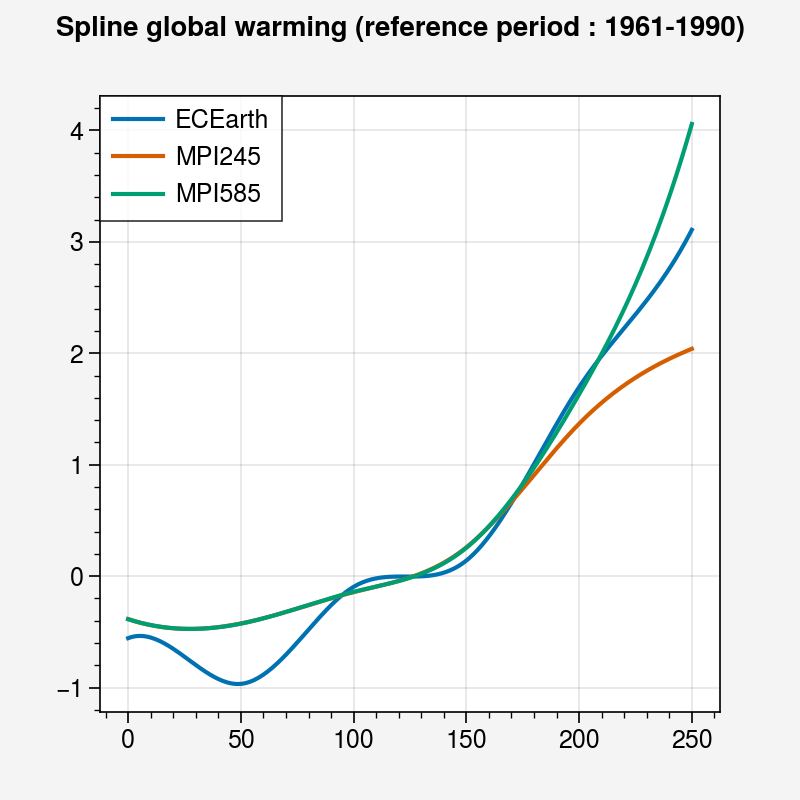

In [19]:
yrly_warming_ECEarth_spline = yrly_tas_ECEarth_globalmean_spline - refperiod_mean_ECEarth_spline

yrly_warming_MPI245_spline = yrly_tas_MPI245_globalmean_spline - refperiod_mean_MPI_spline
yrly_warming_MPI585_spline = yrly_tas_MPI585_globalmean_spline - refperiod_mean_MPI_spline


plt.plot(yrly_warming_ECEarth_spline,label='ECEarth')
plt.plot(yrly_warming_MPI245_spline,label='MPI245')
plt.plot(yrly_warming_MPI585_spline,label='MPI585')

plt.legend()
plt.suptitle('Spline global warming (reference period : 1961-1990)')

#### Trend maps w.r.t. global warming

In [20]:
def slopes_wrt_GCM_warm(MAR_yr_map, GCM_wrming_spline):

    nx = MAR_yr_map.shape[3]
    ny = MAR_yr_map.shape[2]
    
    slope = np.full((ny, nx), np.nan)
    # intercept = np.full((ny, nx), np.nan)
    pval = np.full((ny, nx), np.nan)

    slope_seas = np.full((4,ny, nx), np.nan)
    # intercept_seas = np.full((4,ny, nx), np.nan)
    pval_seas = np.full((4,ny, nx), np.nan)
    
    for i in range(nx):
        for j in range(ny):
            res = linregress(GCM_wrming_spline, MAR_yr_map.mean(axis=1)[:,j,i])
            slope[j, i] = res.slope
            # intercept[j, i] = res.intercept
            pval[j, i] = res.pvalue

            for seas in range(4):
                res = linregress(GCM_wrming_spline, MAR_yr_map[:,seas,j,i])
                slope_seas[seas,j, i] = res.slope
                # intercept_seas[seas,j, i] = res.intercept
                pval_seas[seas,j, i] = res.pvalue

    return slope, pval, slope_seas, pval_seas

In [21]:
ECEarth_precip = np.concatenate([ds_ECEarth_hist_precip.TP.values,ds_ECEarth_SSP245_precip.TP.values],axis=0)
ECEarth_precip.shape

(140, 4, 91, 139)

In [22]:
ds_ECEarth_hist_precip.TP.values.shape

(54, 4, 91, 139)

In [23]:
ECEarth_precip = np.concatenate([ds_ECEarth_hist_precip.TP.values,ds_ECEarth_SSP245_precip.TP.values],axis=0)

slope_ECEarth_yr, pval_ECEarth_yr, slope_ECEarth_seas, pval_ECEarth_seas = slopes_wrt_GCM_warm(ECEarth_precip, yrly_warming_ECEarth_spline[111:])

In [24]:
ds_ECEarth_hist_precip.TP.values.shape

(54, 4, 91, 139)

In [25]:
ECEarth_precip_refperiod = ds_ECEarth_hist_precip.TP.values[:30].mean(axis=0)

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

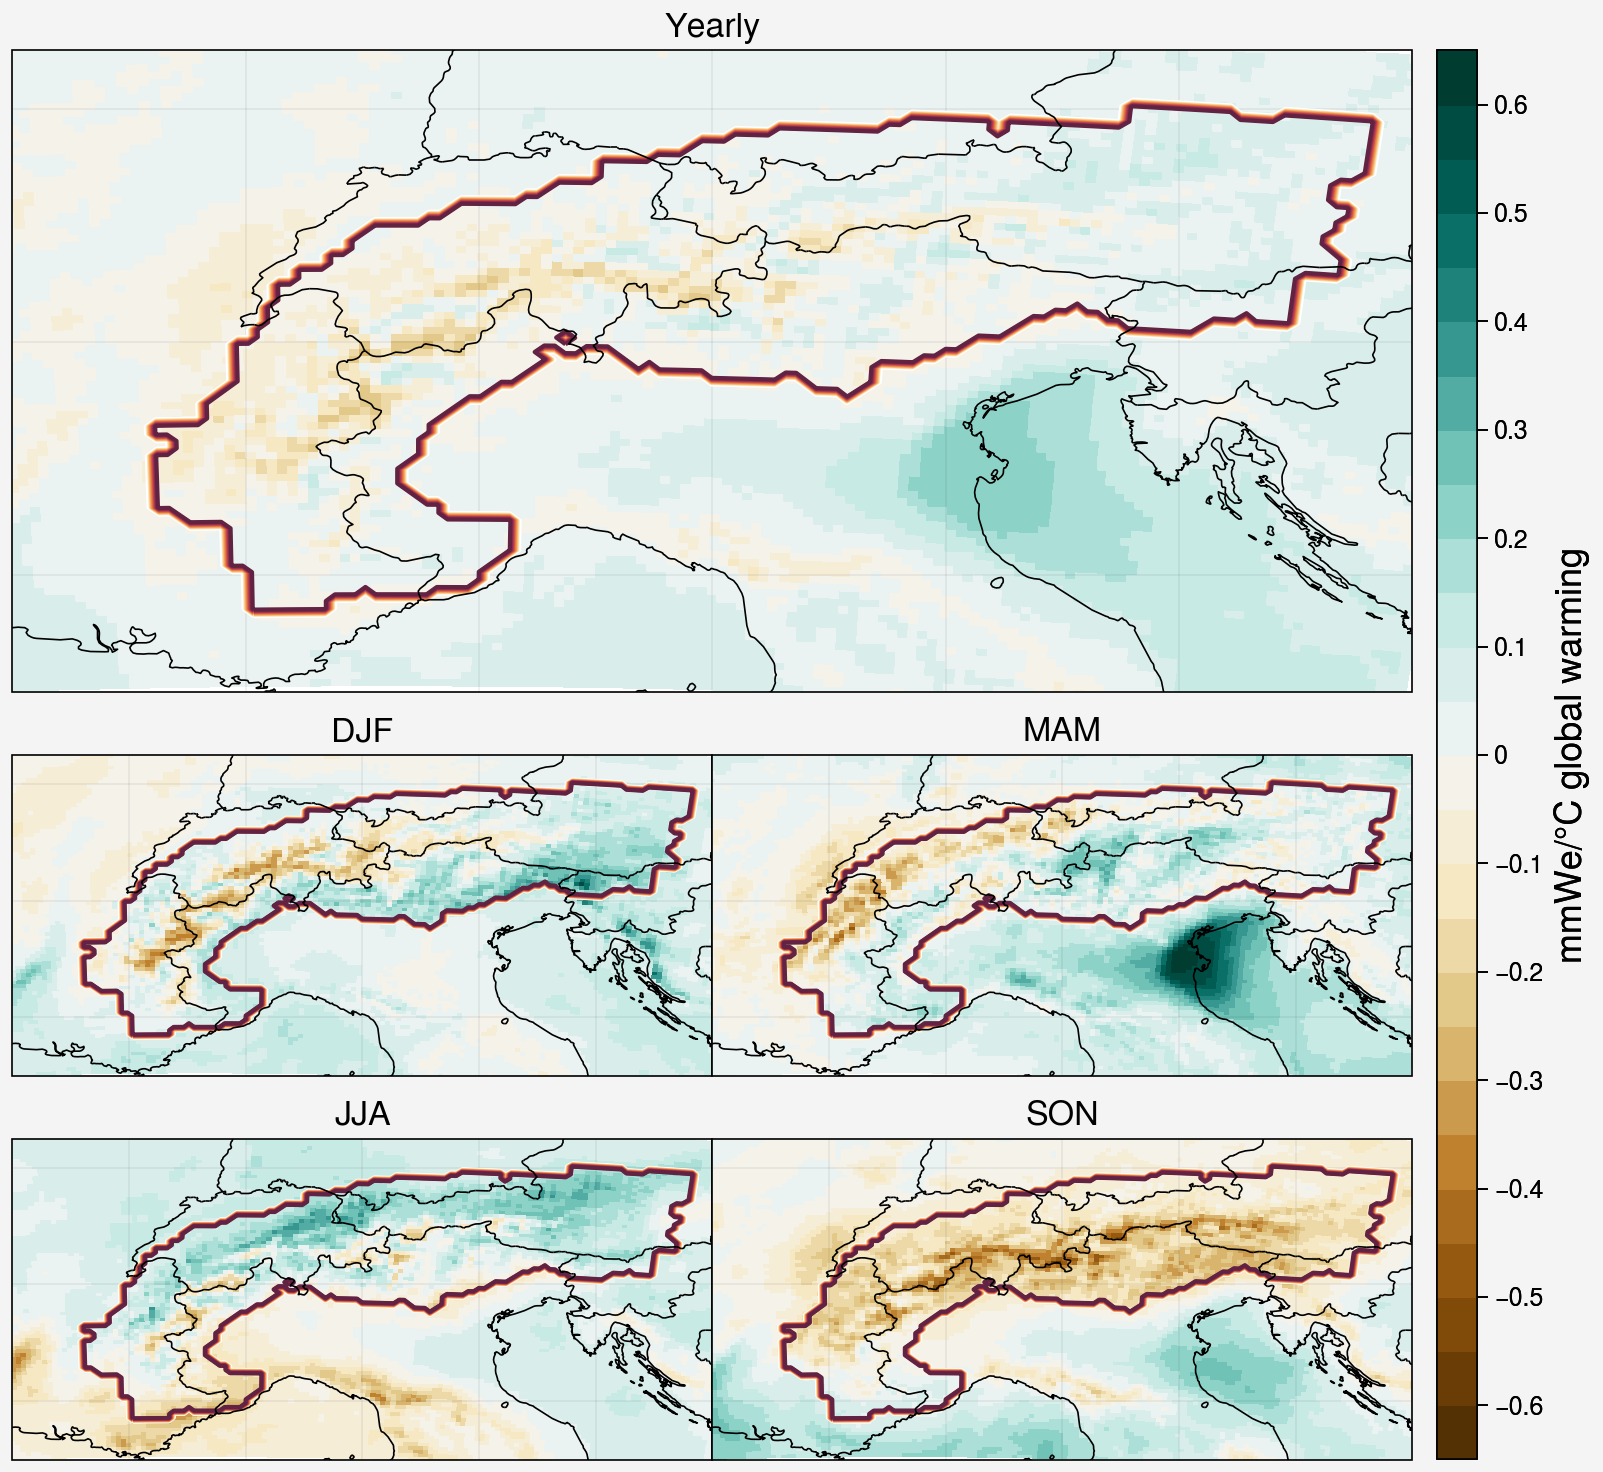

In [26]:
colmap = 'BrBG'
## Normalize so that 1 is the "pivot"
#norm = mcolors.TwoSlopeNorm(vmin=0., vcenter=1.0, vmax=2.)

f, axs = pplt.subplots([[1, 1], [1, 1], [2, 3], [4, 5]], refnum=1, refwidth=7, proj='cyl')#,axwidth=3)

#lvls_range = np.linspace(0.75,1.75,21)
lvls_range = np.linspace(-0.65,0.65,27)

m = axs[0].pcolormesh(lon,lat,slope_ECEarth_yr,levels=lvls_range,cmap=colmap)#,norm=norm)
axs[0].contour(lon, lat,alps)
axs[0].format(title='Yearly',titlesize='17px')

for seas in [1,2,3,4]:
    axs[seas].pcolormesh(lon,lat,slope_ECEarth_seas[seas-1],levels=lvls_range,cmap=colmap)#,norm=norm)
    axs[seas].format(title=['DJF','MAM','JJA','SON'][seas-1],titlesize='17px')
    axs[seas].contour(lon, lat,alps)

f.colorbar(m, label= 'mmWe/°C global warming',labelsize='x-large',ticks=0.1)

axs.format(**multiplot_format)#,suptitle="Year",suptitlesize='16px')

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

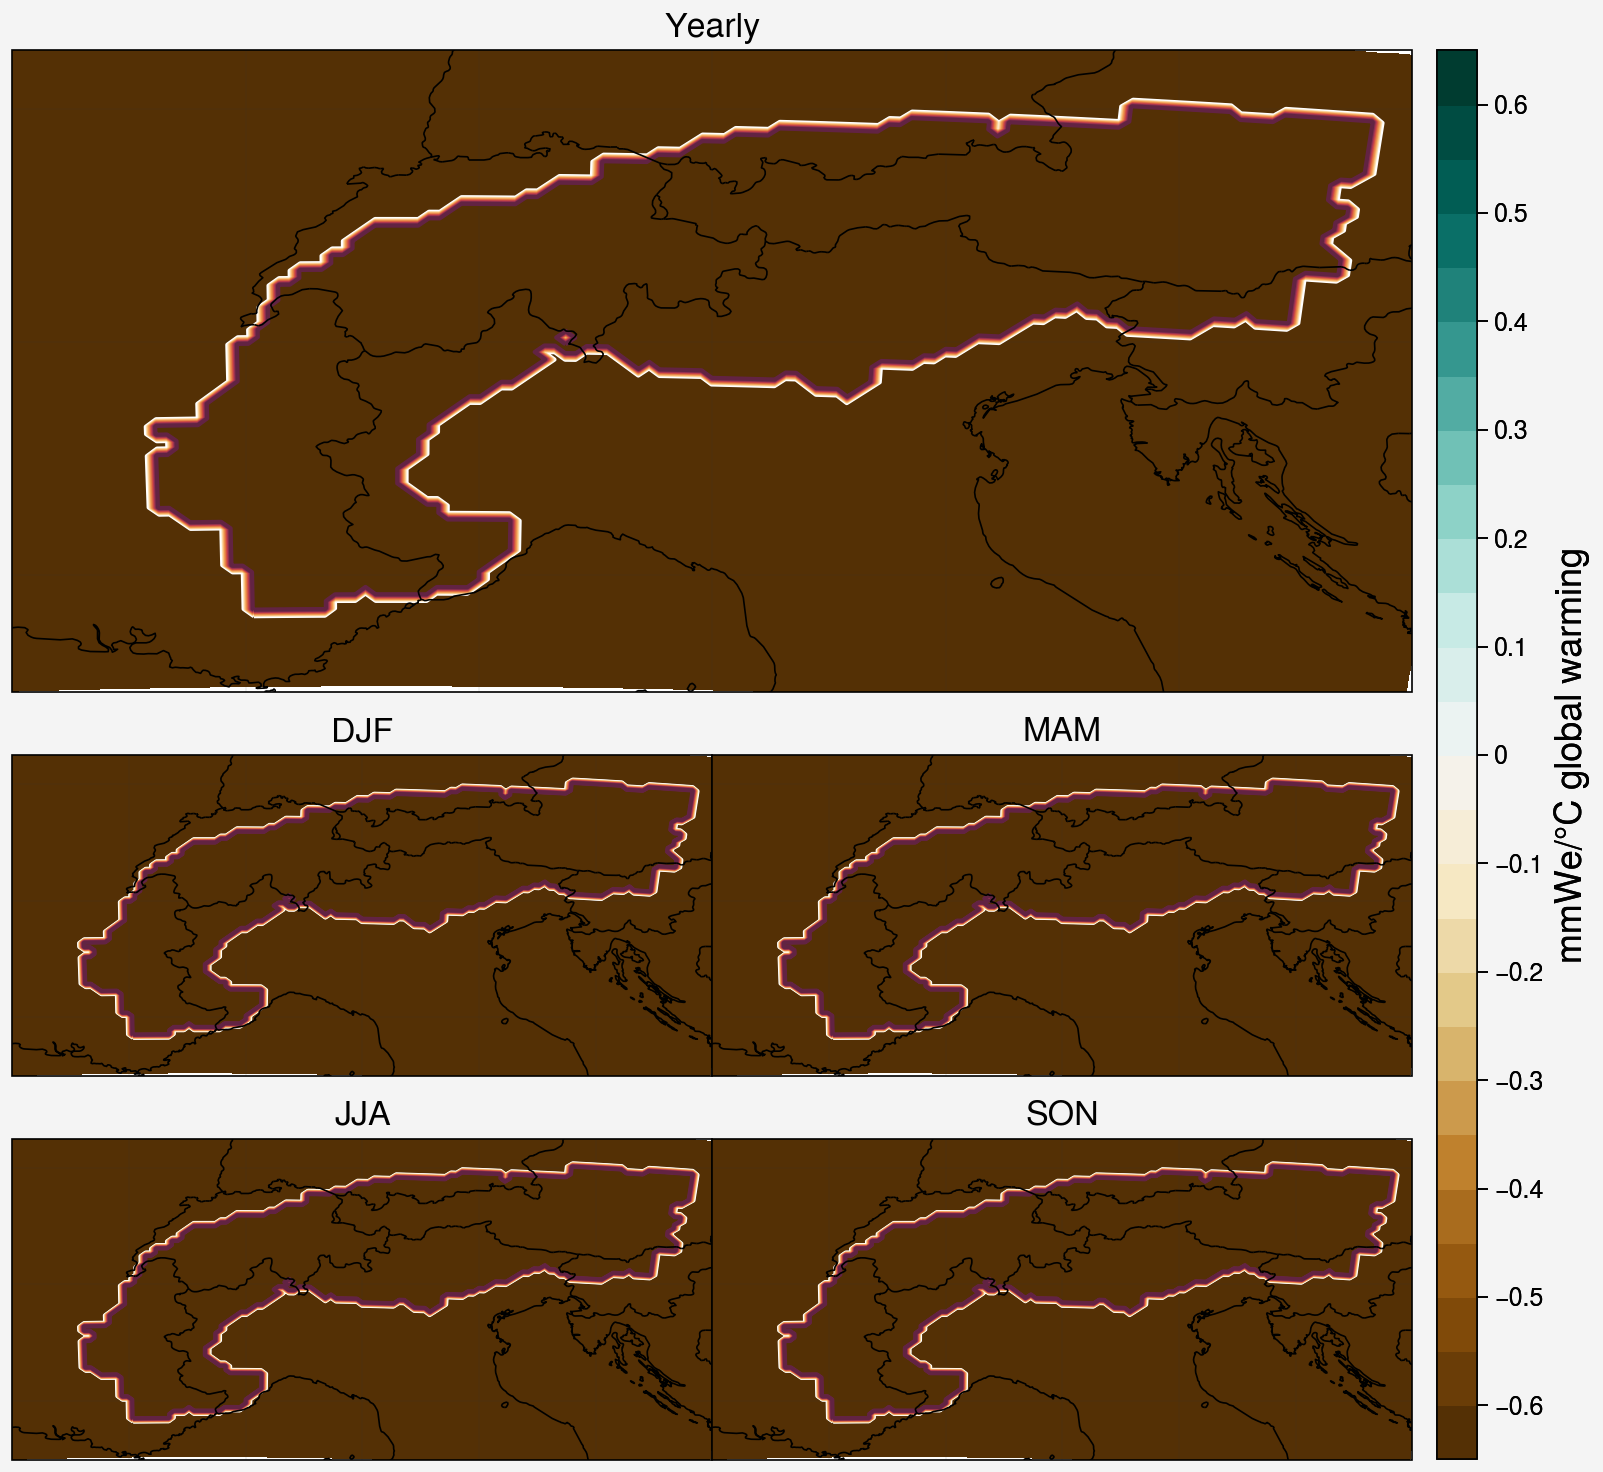

In [27]:
colmap = 'BrBG'
## Normalize so that 1 is the "pivot"
#norm = mcolors.TwoSlopeNorm(vmin=0., vcenter=1.0, vmax=2.)

f, axs = pplt.subplots([[1, 1], [1, 1], [2, 3], [4, 5]], refnum=1, refwidth=7, proj='cyl')#,axwidth=3)

#lvls_range = np.linspace(0.75,1.75,21)
lvls_range = np.linspace(-0.65,0.65,27)

m = axs[0].pcolormesh(lon,lat,(slope_ECEarth_yr-ECEarth_precip_refperiod.mean(axis=0))/ECEarth_precip_refperiod.mean(axis=0)*100,
                      levels=lvls_range,cmap=colmap)#,norm=norm)
axs[0].contour(lon, lat,alps)
axs[0].format(title='Yearly',titlesize='17px')

for seas in [1,2,3,4]:
    axs[seas].pcolormesh(lon,lat,(slope_ECEarth_seas[seas-1]-ECEarth_precip_refperiod[seas-1])/ECEarth_precip_refperiod[seas-1]*100,
                         levels=lvls_range,cmap=colmap)#,norm=norm)
    axs[seas].format(title=['DJF','MAM','JJA','SON'][seas-1],titlesize='17px')
    axs[seas].contour(lon, lat,alps)

f.colorbar(m, label= 'mmWe/°C global warming',labelsize='x-large',ticks=0.1)

axs.format(**multiplot_format)#,suptitle="Year",suptitlesize='16px')